# Packages

In [45]:
#Data handling
import pandas as pd
import numpy as np
#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Data modeling
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Data loading and preparation

In [12]:
df = pd.read_csv('raw_data/Mental_health_Depression_disorder_Data.csv').dropna()

/var/folders/4q/jy5tm04141s0j174dgw0xcsm0000gn/T/ipykernel_34996/646241924.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('raw_data/Mental_health_Depression_disorder_Data.csv').dropna()


In [13]:
df.head(5)

,index,Entity,Code,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
0,0,Afghanistan,AFG,1990,0.16056,0.697779,0.101855,4.828830,1.677082,4.071831,0.672404
1,1,Afghanistan,AFG,1991,0.160312,0.697961,0.099313,4.829740,1.684746,4.079531,0.671768
2,2,Afghanistan,AFG,1992,0.160135,0.698107,0.096692,4.831108,1.694334,4.088358,0.670644
3,3,Afghanistan,AFG,1993,0.160037,0.698257,0.094336,4.830864,1.705320,4.096190,0.669738
4,4,Afghanistan,AFG,1994,0.160022,0.698469,0.092439,4.829423,1.716069,4.099582,0.669260


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5488 entries, 0 to 6467
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      5488 non-null   int64  
 1   Entity                     5488 non-null   object 
 2   Code                       5488 non-null   object 
 3   Year                       5488 non-null   object 
 4   Schizophrenia (%)          5488 non-null   object 
 5   Bipolar disorder (%)       5488 non-null   object 
 6   Eating disorders (%)       5488 non-null   object 
 7   Anxiety disorders (%)      5488 non-null   float64
 8   Drug use disorders (%)     5488 non-null   float64
 9   Depression (%)             5488 non-null   float64
 10  Alcohol use disorders (%)  5488 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 514.5+ KB


In [16]:
#Cleaning the data
df['Year'] = df['Year'].astype(int)
df[df.columns[4:]] = df[df.columns[4:]].astype(float)

In [17]:
#Determining the target and features
y = np.array(df[df['Year'] == 2017]['Depression (%)'])
X =df[df['Year']!= 2017][['Entity', 'Year' ,'Depression (%)','Schizophrenia (%)',
       'Bipolar disorder (%)', 'Eating disorders (%)', 'Anxiety disorders (%)',
       'Drug use disorders (%)',
       'Alcohol use disorders (%)']]

In [20]:
# Pivot the dataframe
pivot_df = X.pivot(index='Entity', columns='Year')

# Get the values as a numpy array
tensor_array = pivot_df.values

In [23]:
tensor_array.shape

(196, 189)

In [24]:
X['Year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

In [25]:
# Reshape the numpy array to create a tensor
num_countries = len(X['Entity'].unique())
num_years = len(X['Year'].unique())
num_features = X.shape[1] - 2  # Exclude 'Country' and 'Year' columns
X = tensor_array.reshape(num_countries, num_years , num_features )

In [26]:
X.shape, y.shape

((196, 27, 7), (196,))

# Time course visualization

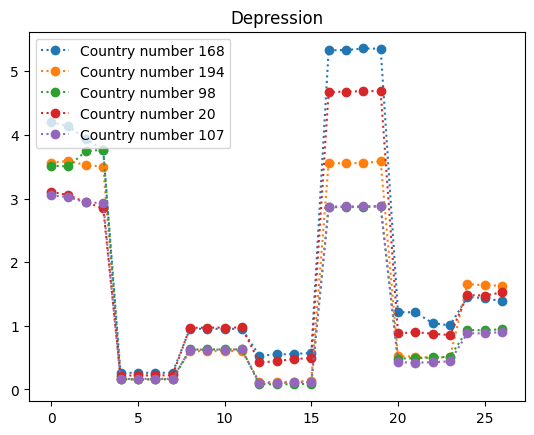

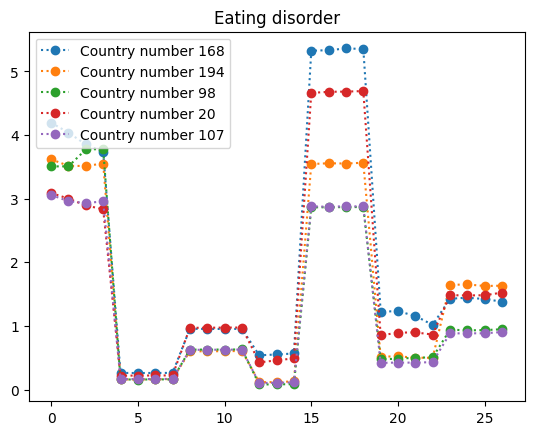

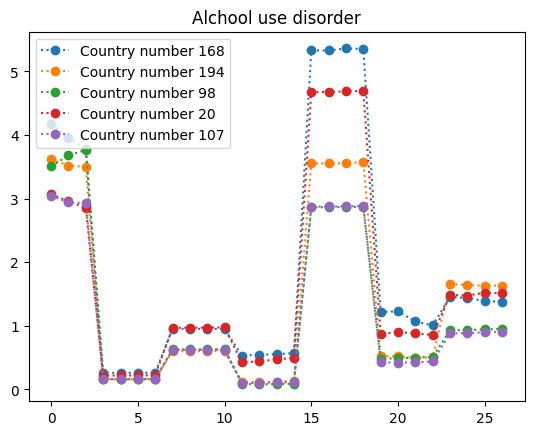

In [30]:
%matplotlib inline
number_of_countries = len(X)
### Choosing random countries
##### As the countries are selected randomly, feel free to re-run this cell a few times !
number_of_randomly_selected_countries = 5
random_selection = np.random.randint(0,
                                     number_of_countries,
                                     number_of_randomly_selected_countries)
### Plotting data for the selected countries

plt.title('Depression')
for r in random_selection:
    plt.plot(X[r, :, 0],label=f"Country number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

plt.title('Eating disorder')
for r in random_selection:
    plt.plot(X[r, :, 3],label=f"Country number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

plt.title('Alchool use disorder')
for r in random_selection:
    plt.plot(X[r, :, -1],label=f"Country number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

# Data modeling 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((156, 27, 7), (40, 27, 7), (156,), (40,))

In [41]:
# Define a custom normalization layer
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = None
        self.std = None

    def forward(self, x):
        if self.mean is None or self.std is None:
            raise ValueError("Normalization parameters not initialized.")
        return (x - self.mean) / self.std

    def adapt(self, X_train):
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert to PyTorch tensor
        self.mean = torch.mean(X_train_tensor, dim=0)
        self.std = torch.std(X_train_tensor, dim=0)


In [42]:
# Define the RNN model architecture
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.normalizer = Normalization()  # Instantiate the normalization layer
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        # Adapt the normalization layer to the input data
        self.normalizer.adapt(x)
        # Normalize the input data
        x = self.normalizer(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Get the output of the last time step
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Instantiate the RNN model
input_size = X_train.shape[2]
hidden_size = 20
output_size = 1
model = RNNModel(input_size, hidden_size, output_size)


In [43]:
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.RMSprop(model.parameters())

# Define the evaluation metric
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

# Compile the model
def compile_model(model, optimizer, loss, metrics):
    model.optimizer = optimizer
    model.loss = loss
    model.metrics = metrics
    return model  # Return the compiled model

# Compile the model
model = compile_model(model, optimizer, criterion, mean_absolute_error)


In [44]:
X_train.shape

(156, 27, 7)

In [46]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define the model architecture
#model = model(input_size)  # Define your model with the appropriate input size

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for inputs, targets in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


/var/folders/4q/jy5tm04141s0j174dgw0xcsm0000gn/T/ipykernel_34996/1922273700.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert to PyTorch tensor
/Users/michele/.pyenv/versions/3.10.6/envs/mehefo/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/michele/.pyenv/versions/3.10.6/envs/mehefo/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to i

Epoch 1/100, Train Loss: 10.0839, Val Loss: 10.2399
Epoch 2/100, Train Loss: 9.5301, Val Loss: 9.6262
Epoch 3/100, Train Loss: 8.8927, Val Loss: 8.9448
Epoch 4/100, Train Loss: 8.2117, Val Loss: 8.1722
Epoch 5/100, Train Loss: 7.4005, Val Loss: 7.2779
Epoch 6/100, Train Loss: 6.4579, Val Loss: 6.2932
Epoch 7/100, Train Loss: 5.4978, Val Loss: 5.2594
Epoch 8/100, Train Loss: 4.4749, Val Loss: 4.2344
Epoch 9/100, Train Loss: 3.5344, Val Loss: 3.2823
Epoch 10/100, Train Loss: 2.6809, Val Loss: 2.4700
Epoch 11/100, Train Loss: 1.9600, Val Loss: 1.7992
Epoch 12/100, Train Loss: 1.3847, Val Loss: 1.2901
Epoch 13/100, Train Loss: 0.9680, Val Loss: 0.9306
Epoch 14/100, Train Loss: 0.6984, Val Loss: 0.6998
Epoch 15/100, Train Loss: 0.5297, Val Loss: 0.5715
Epoch 16/100, Train Loss: 0.4412, Val Loss: 0.5119
Epoch 17/100, Train Loss: 0.4096, Val Loss: 0.4903
Epoch 18/100, Train Loss: 0.3999, Val Loss: 0.4855
Epoch 19/100, Train Loss: 0.4046, Val Loss: 0.4854
Epoch 20/100, Train Loss: 0.4063, Val 

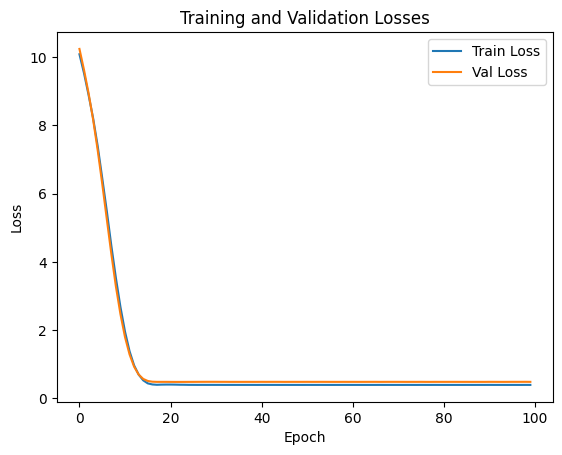

In [47]:
# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [48]:
import torch
import torch.nn as nn

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Pass the test data through the model
with torch.no_grad():
    outputs = model(X_test_tensor)

# Compute the absolute errors
abs_errors = torch.abs(outputs - y_test_tensor)

# Compute the mean absolute error
mae = torch.mean(abs_errors)

print(f'Model Mean Absolute Error: {mae.item():.4f}')


Model Mean Absolute Error: 0.5646


/var/folders/4q/jy5tm04141s0j174dgw0xcsm0000gn/T/ipykernel_34996/1922273700.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert to PyTorch tensor


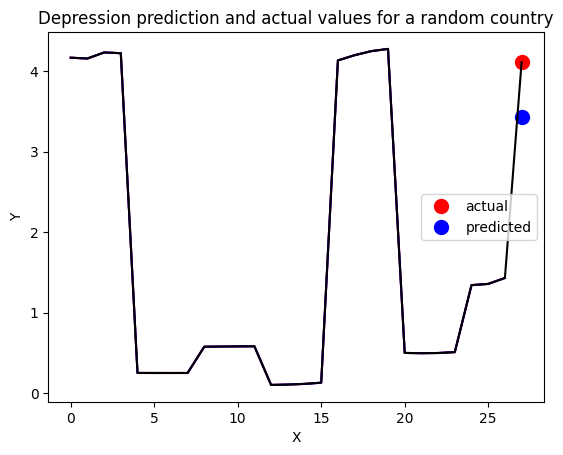

In [71]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define the interval
start = 0
end = 39  # Adjust the interval as needed

# Generate a random integer within the interval [start, end]
i = random.randint(start, end)

# Get the predicted and actual values for the random index
predicted = np.append(X_test[i, :, 0], outputs[i])
actual = np.append(X_test[i, :, 0], y_test[i])

# Sample data
x = np.linspace(0, 27, 28)
y1 = predicted
y2 = actual

plt.plot(x[:-1], y2[:-1], color='red')
plt.plot(x[-1], y2[-1], 'ro', label='actual', markersize=10)
plt.plot(x[:-1], y1[:-1], color='blue')
plt.plot(x[-1], y1[-1], 'bo', label='predicted', markersize=10)


# Identify the overlapping region
overlap = np.logical_and(y1 > 0, y2 > 0)

# Plot the overlapping part with a black line
plt.plot(x[overlap], y2[overlap], color='black')

# Add legend and labels
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Depression prediction and actual values for a random country')

# Show plot
plt.show()
